Epoch 000: Loss: 2.530, Accuracy: 20.784%
Epoch 001: Loss: 2.112, Accuracy: 35.294%
Epoch 002: Loss: 1.823, Accuracy: 51.765%
Epoch 003: Loss: 1.600, Accuracy: 61.569%
Epoch 004: Loss: 1.413, Accuracy: 69.412%
Epoch 005: Loss: 1.266, Accuracy: 75.882%
Epoch 006: Loss: 1.143, Accuracy: 80.980%
Epoch 007: Loss: 1.036, Accuracy: 83.725%
Epoch 008: Loss: 0.945, Accuracy: 86.863%
Epoch 009: Loss: 0.862, Accuracy: 90.588%
Epoch 010: Loss: 0.798, Accuracy: 92.941%
Epoch 011: Loss: 0.734, Accuracy: 95.098%
Epoch 012: Loss: 0.679, Accuracy: 95.294%
Epoch 013: Loss: 0.633, Accuracy: 96.275%
Epoch 014: Loss: 0.590, Accuracy: 97.059%
Epoch 015: Loss: 0.552, Accuracy: 97.451%
Epoch 016: Loss: 0.517, Accuracy: 97.843%
Epoch 017: Loss: 0.487, Accuracy: 98.235%
Epoch 018: Loss: 0.459, Accuracy: 98.627%
Epoch 019: Loss: 0.433, Accuracy: 99.020%
Epoch 020: Loss: 0.409, Accuracy: 99.020%
Epoch 021: Loss: 0.389, Accuracy: 99.216%
Epoch 022: Loss: 0.369, Accuracy: 99.216%
Epoch 023: Loss: 0.350, Accuracy: 

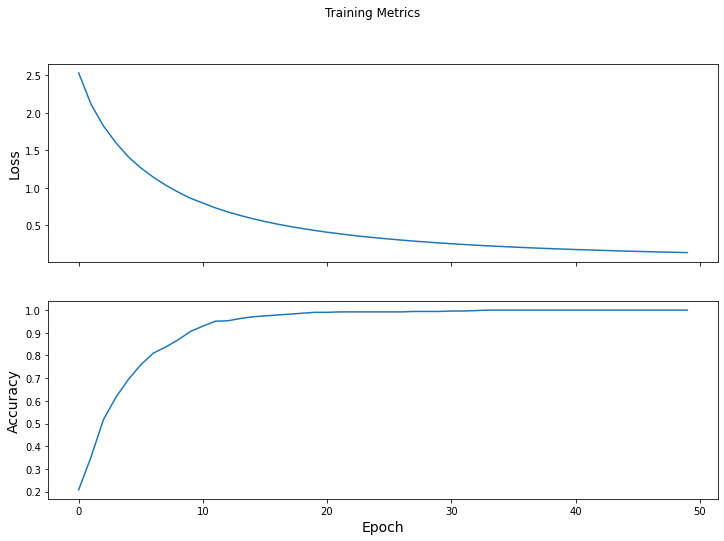

Test set accuracy: 82.500%
[<tf.Tensor: shape=(10,), dtype=int32, numpy=array([4, 4, 4, 4, 5, 5, 5, 5, 6, 6])>, <tf.Tensor: shape=(10,), dtype=int32, numpy=array([6, 6, 7, 7, 7, 7, 9, 9, 9, 9])>, <tf.Tensor: shape=(10,), dtype=int32, numpy=array([9, 2, 4, 2, 0, 0, 0, 0, 1, 1])>, <tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 1, 2, 2, 2, 2, 3, 3, 3, 3])>]
[<tf.Tensor: shape=(10,), dtype=int32, numpy=array([4, 4, 4, 4, 5, 5, 5, 5, 6, 6])>, <tf.Tensor: shape=(10,), dtype=int32, numpy=array([6, 6, 7, 7, 7, 7, 8, 8, 8, 8])>, <tf.Tensor: shape=(10,), dtype=int32, numpy=array([9, 9, 9, 9, 0, 0, 0, 0, 1, 1])>, <tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 1, 2, 2, 2, 2, 3, 3, 3, 3])>]


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

#df = pd.read_csv('T44.csv')
#df.head()

LABEL_COLUMN = 'letter'
LABELS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def get_dataset(file_path, **kwargs):
  dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=10, # Artificially small to make examples easier to show.
      label_name=LABEL_COLUMN,
      na_value="?",
      num_epochs=1,
      shuffle=True,
      ignore_errors=True, 
      **kwargs)
  return dataset

train_dataset = get_dataset('C:\\Users\\Tomi\\Desktop\\jupyter\\TF4.csv')

def show_batch(dataset):
  for batch, label in dataset.take(1):
    for key, value in batch.items():
      print("{:20s}: {}".format(key,value.numpy()))

#show_batch(raw_train_data)
features, labels = next(iter(train_dataset))












def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels


train_dataset = train_dataset.map(pack_features_vector)

features, labels = next(iter(train_dataset))

model = tf.keras.Sequential([
  tf.keras.layers.Dense(170, activation=tf.nn.relu, input_shape=(2500,)),  # input shape required
  #tf.keras.layers.Dense(200, activation=tf.nn.relu),
  tf.keras.layers.Dense(10)
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)





def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)




## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 50

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 1 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))


#Visualize the loss function over time  ; you really want to see the loss go down and the accuracy go up
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()


#model.save("my_model")         #to save model
#reconstructed_model = keras.models.load_model("my_model")         to load model
#reconstructed_model.summary()

################################################################## to test the model

def get_testset(file_path, **kwargs):
  dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size = 10,
      label_name= "predict",
      na_value="?",
      num_epochs=1,
      shuffle=False, 
      **kwargs)
  return dataset


  

test_dataset = get_testset('C:\\Users\\Tomi\\Desktop\\jupyter\\to.csv')
test_dataset = test_dataset.map(pack_features_vector)


test_accuracy = tf.keras.metrics.Accuracy()
predictss = []
zyz = []
for (x, y) in test_dataset:
  # training=False is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  logits = model(x, training=False)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)
  predictss.append(prediction)              # to get model predictions ; y is the labels
  zyz.append(y)
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))
#tf.stack([y,prediction],axis=1)
print(predictss)
print(zyz)


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

reconstructed_model = keras.models.load_model("my_model")
df = pd.read_csv('tom.csv',header=None)
dax = df.values
predict_dataset = tf.convert_to_tensor(dax)

predictions = reconstructed_model(predict_dataset, training=False)
for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))



Example 0 prediction: 4 (61.2%)
Example 1 prediction: 4 (98.6%)
Example 2 prediction: 4 (86.4%)
Example 3 prediction: 4 (81.7%)
Example 4 prediction: 5 (58.4%)
Example 5 prediction: 5 (46.8%)
Example 6 prediction: 5 (46.0%)
Example 7 prediction: 5 (70.9%)
Example 8 prediction: 6 (86.2%)
Example 9 prediction: 6 (96.5%)
Example 10 prediction: 6 (98.3%)
Example 11 prediction: 6 (77.3%)
Example 12 prediction: 7 (58.5%)
Example 13 prediction: 7 (81.2%)
Example 14 prediction: 7 (47.7%)
Example 15 prediction: 7 (50.8%)
Example 16 prediction: 9 (34.2%)
Example 17 prediction: 9 (56.9%)
Example 18 prediction: 4 (47.5%)
Example 19 prediction: 9 (34.2%)
Example 20 prediction: 9 (33.9%)
Example 21 prediction: 2 (29.5%)
Example 22 prediction: 9 (54.1%)
Example 23 prediction: 2 (61.3%)
Example 24 prediction: 0 (96.9%)
Example 25 prediction: 0 (96.5%)
Example 26 prediction: 0 (94.7%)
Example 27 prediction: 0 (97.0%)
Example 28 prediction: 1 (38.5%)
Example 29 prediction: 1 (89.8%)
Example 30 predictio